# Time Series Forecasting using Deep Neural Network
**Created: Jan. 8, 2019**
> This notebook demonstrates a one-step forecasting scheme using deep neural networks. This can be considered as a benchmark for neural networks' forecasting performance

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import os
import sys
from pprint import pprint
from dateutil.relativedelta import *

In [2]:
# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
from pylab import rcParams

In [3]:
# Customized packages
sys.path.append("../")
import core.tools.json_rec as json_rec
import nn_methods
import df_methods
import os_methods
from typing import List, Tuple

## CONTROL PANEL
> Modify model hyper-parameters here
#### Data Parameters:
- `file_dir`: the directory of dataset csv file.

- `fea(ture)_name`: a list of feature variable(s). If univaraite series is used, the feature and label variables 
collide and one should put `None` here.

- `lab(el)_name`: the name of label variable.

- `(P, D)` $\in \mathbb{N}^2$: integers similar to the $(p,d,q)$ parameter in an ARIMA model, but we did not put a $q$ parameter here. Differencing parameter $d$ should be 1 or higher in order to make the series stationary. (See below for more information)

#### Neural Network Parameters:
- `num_inputs` $\in \mathbb{N}$: the number of input features. So the actual size of each $\vec{x}$ to our neural network has size $$P \times num\_inputs$$
In multi-variate series forecasting tasks, it must be the length of `FEA_NAME` list.

- `num_outputs` $\in \mathbb{N}$: the number of label features, must be 1 in the standard model. It would be set to a higher integer if we wish to forecast multiple time series the same time.

- `l(earning_)r(ate)` $\in \mathbb{R}_{++}$: the learning rate used while training the neural net.

- `epochs` $\in \mathbb{N}$: the number of training epochs. If one wish the session to automatically stop when there's no further significant improvement on the validation set loss, set `EPOCHS=None`

#### Optional Parameters
- `patient` $\in \mathbb{N}$: only needed when `EPOCHS == None`, see **early-stopping** section below.

- `eposilon`($\epsilon \in \mathbb{R}_+$): only needed when `EPOCHS == None`, see **early-stopping** section below.

In [4]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
PARAMS = dict(
    model_type = "Univariate one step DNN",
    ipynb = "ts_dnn.ipynb",
    # File IO
    file_dir = "./data/UNRATE.csv",
    fea_name = None,
    lab_name = "UNRATE",
    # Data Preprocessing
    P = 6,
    D = 1,
    # Model Settings
    num_inputs = 1,
    num_outputs = 1,
    neurons = [32, 64],
    # Model Training
    lr = 0.01,
    epochs = None,
    patient = 100,
    epsilon = 1e-8
)

## CREATE EXPERIMENT RECORD FILE

In [5]:
base_dir = f"./saved/{now}"
paths = os_methods.create_record(base_dir)

Creating directory: ./saved/2019-01-09_23:06:59
Creating directory: ./saved/2019-01-09_23:06:59/tensorboard
Creating directory: ./saved/2019-01-09_23:06:59/fig
Creating directory: ./saved/2019-01-09_23:06:59/outputs
Creating directory: ./saved/2019-01-09_23:06:59/present


## LOAD THE DATASET

In [6]:
# globals().update(PARAMS)

In [7]:
df = pd.read_csv(PARAMS["file_dir"], index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = [PARAMS["lab_name"]]
print(df.dtypes)
print(df.head())
print(df.describe())
# month_df = df.resample("M").mean().head()

UNRATE    float64
dtype: object
            UNRATE
DATE              
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5
           UNRATE
count  852.000000
mean     5.763028
std      1.638414
min      2.500000
25%      4.600000
50%      5.600000
75%      6.800000
max     10.800000


## Formulate THE SUPERVISED LEARNING PROBLEM
#### The Objective
We formulate the forecasting problem as a <u>supervised learning problem</u>, so taht we can train a neural net to fit it with usual optimizers (like SGD or Adam).

For simplicity, consider an <u>uni-variate</u> series observed:
$$
I = \{y_t\}_{t \in \Psi}
$$
where $\Psi$ is a set of <u>datetime</u> objects. We define $\Psi$ as the **time stamp** sequence, and denote the terminal time period as $T$.

#### Assumption
We only consider time series with <u>finite</u> time stamp sequence $\Psi$.


#### Example
The time stamp sequence for a typical *yearly* series would look like $\Psi = (1950, 1951, \dots, 2001, 2012)$.

#### Forecasting
Given `periods` parameter $p \in \mathbb{N}$, the forecast for any time step $t$ would be a function 
$$
g \in \mathbb{R}^{\mathbb{R}^p}
$$
i.e. $g: \mathbb{R}^p \to \mathbb{R}$. That's, the <u>one step forward forecast made at time $t-1$</u>, which is equivalent to the predicted value $\hat{y}_t$ can be written as:
$$
f_{t-1,1} \equiv g(y_{t-p}, \dots, y_{t-1})
$$

and the forecasting error is given by
$$
e_t(g) = y_t - f_{t-1, 1} \equiv y_t - g(\{y_{\tau}\}_{\tau \in \{t-p, \dots, t-1\}})
$$

#### The Neural Network
And the nueral network model is basically a composite of product of matrices and activation functions.

A fully connected neural network gives a transformation 
$$
    \hat{g}: \mathbb{R}^p \to \mathbb{R}
$$
And the network is trained to minimize some error measure on the training set $\{e_t(g)\}_{t \in \Psi}$.

Typically, mean-squared-error is taken as the objective function (loss function):

$$
MSE(g, I) = \frac{1}{|\Psi|} \sum_{t \in \Psi} (y_t - f_{t-1, 1})^2
\equiv \frac{1}{|\Psi|} \sum_{t \in \Psi} \Big( y_t - g(y_{t-p}, \dots, y_{t-1}) \Big)^2
$$

Let $\mathcal{F} \subseteq \mathbb{R}^{\mathbb{R}^p}$ denote the set of functions that can <u>possibly</u> be represented by a neural network.

Therefore, the neural network is trained so that the transformation $\hat{g}$ it gives satisfies
$$
    \hat{g} \approx argmin_{g \in \mathcal{F}} MSE(g, I)
$$

### Training Instance Tuples
Consider the collection of information above, we can generate a corresponding instance for each $t \in \Psi \backslash \{1, 2, \dots, p\}$.

Define
$$
    \Psi' \equiv \Psi \backslash \{1, 2, \dots, p\}
$$

The training session for the neural net takes a <u>collection of instances</u>,
$$ 
    \Omega = (\textbf{X}, \textbf{y}, \textbf{t}) \equiv \{\omega_\tau\}_{\tau \in \Psi'}
$$ as data feed.

Each element in the collection is a triple containing **feature**, **label** and **time stamp**:
$$
    \omega_t = (\textbf{x}_t, y_t, t) \in \Omega
$$

In our univariate case, $\omega_t$ can be generated by taking
$$
    \begin{cases}
        \omega[0] \equiv \textbf{x}_t := (y_{t-p}, y_{t-p+1}, \dots, y_{t-2}, y_{t-1}) \\
        \omega[1] \equiv y_t := y_t \\
        \omega[2] := t
    \end{cases}
$$

**Note** that $t$ can be dropped and each instance $\omega_t$ can be reduced to 
$$
    \omega_t' = (\textbf{x}_t, y_t)
$$
we put $t$ here to make the invert-differencing process easier.

In [8]:
diff = df.diff()  #  Take the first order differenced.
diff.dropna(inplace=True)
slp = nn_methods.gen_slp(
    df=diff,
    num_time_steps=PARAMS["P"],
    sequential=False
)

Failed time step ignored: 845
Failed time step ignored: 846
Failed time step ignored: 847
Failed time step ignored: 848
Failed time step ignored: 849
Failed time step ignored: 850


### Check the validity of instances

In [9]:
for (x, y, t) in slp:
    assert diff[PARAMS["lab_name"]][t] == y
    for delta in range(1, PARAMS["P"] + 1):
        t_back = t + relativedelta(months=-delta)
        assert diff[PARAMS["lab_name"]][t_back] == x[-delta]

### Transform instance collections into numpy array
Consider a collection of information $I = \{y_t\}_{t \in \Psi}$ and the collection of instances generated from it,
$$
    \Omega = (\textbf{X}, \textbf{y}, \textbf{t}) \equiv \{\omega_\tau\}_{\tau \in \Psi'}
$$

Let $n \equiv |\mathcal{T}|$ denote the <u>size</u> of $\Omega$, which is the total number of instances.

Then $\textbf{X}$ would be reshaped into $(n, num\_inputs \times P)$

$\textbf{y}$ would be reshaped into $(n, num\_outputs)$.

And $\textbf{t}$ is an array of datetime objects with length $n$.

In [10]:
X = np.squeeze([p[0] for p in slp])
X = X.reshape(-1, PARAMS["num_inputs"] * PARAMS["P"])
y = np.squeeze([p[1] for p in slp])
y = y.reshape(-1, PARAMS["num_outputs"])
ts = [p[2] for p in slp]

In [11]:
print(f"X shape={X.shape}")
print(f"y shape={y.shape}")

X shape=(845, 6)
y shape=(845, 1)


## SPLITTING THE DATASET
We split the dataset into three <u>disjoint subsets</u>, namely the training, validation and testing sets.

#### Note
Preserving the chronological order while splitting the dataset to make it easier to be visualized.

In real applications, we can <u>shuffle</u> the first $\alpha \% + \beta \%$ of time stamps before splitting it into training and validation sets.


#### Training Set
$$
    I_{train} \equiv \{\omega_t: t \in \text{first $\alpha \%$ time stamps in $T$}\}
$$

#### Validation Set
$$
    I_{validation} \equiv \{\omega_t: t \in \text{between $\alpha \%$ and $\alpha \% + \beta \%$time stamps in $T$}\}
$$

#### Testing Set
$$
    I_{test} \equiv \{\omega_t: t \in \text{the last $100\% - \alpha \% - \beta \%$ time stamps in $T$}\}
$$


In [12]:
total = len(y)
X_train, y_train, ts_train =\
X[:int(total*0.6), :],\
y[:int(total*0.6), :],\
ts[:int(total*0.6)]

In [13]:
X_val, y_val, ts_val =\
X[int(total*0.6): int(total*0.8), :],\
y[int(total*0.6): int(total*0.8), :],\
ts[int(total*0.6): int(total*0.8)]

In [14]:
X_test, y_test, ts_test =\
X[int(total*0.8):, :],\
y[int(total*0.8):, :],\
ts[int(total*0.8):]

In [15]:
for s in ["train", "val", "test"]:
    for obj in ["X", "y"]:
        print(f"{obj}_{s} shape:")
        exec(f"print({obj}_{s}.shape)")

X_train shape:
(507, 6)
y_train shape:
(507, 1)
X_val shape:
(169, 6)
y_val shape:
(169, 1)
X_test shape:
(169, 6)
y_test shape:
(169, 1)


## VISUALIZATION OF DATASETS

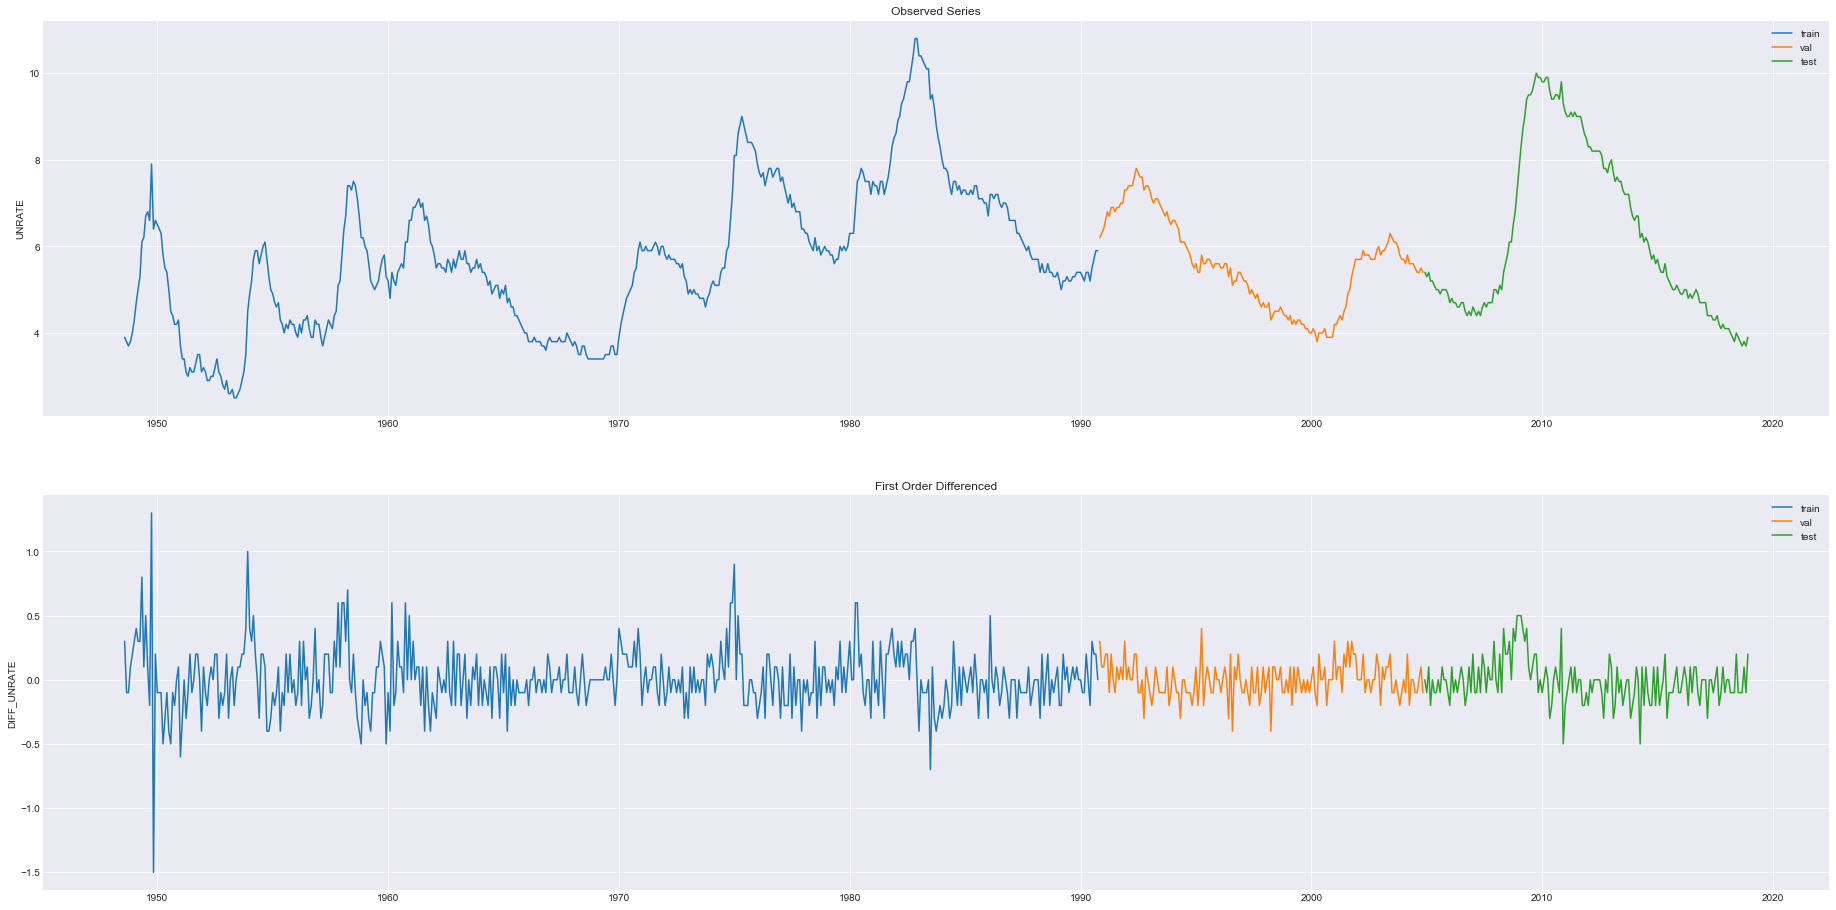

In [16]:
plt.close()
rcParams["figure.figsize"] = (32, 16)
ax1 = plt.subplot(2, 1, 1)
plt.title("Observed Series")
plt.plot(ts_train, df[PARAMS["lab_name"]][ts_train], label="train")
plt.plot(ts_val, df[PARAMS["lab_name"]][ts_val], label="val")
plt.plot(ts_test, df[PARAMS["lab_name"]][ts_test], label="test")
plt.legend()
plt.ylabel(PARAMS["lab_name"])
plt.grid(True)

ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("First Order Differenced")
plt.plot(ts_train, y_train, label="train")
plt.plot(ts_val, y_val, label="val")
plt.plot(ts_test, y_test, label="test")
plt.legend()
plt.ylabel("DIFF_" + PARAMS["lab_name"])
plt.grid(True)

plt.savefig(paths["fig"] + "/raw.png", dpi=600)
plt.show()

## BIULDING THE NEURAL NETWORK

In [17]:
tf.reset_default_graph()
with tf.name_scope("DATA_IO"):
    X = tf.placeholder(
        tf.float32,
        [None, PARAMS["P"]],
        name="FEATURE"
    )
    
    y = tf.placeholder(
        tf.float32,
        [None, PARAMS["num_outputs"]],
        name="LABEL"
    )

In [18]:
with tf.name_scope("DENSE"):
    W1 = tf.Variable(tf.random_normal(
        [PARAMS["P"], PARAMS["neurons"][0]], name="W1"))
    
    b1 = tf.Variable(tf.random_normal([1, PARAMS["neurons"][0]], name="b1"))
    
    W2 = tf.Variable(tf.random_normal(
        [PARAMS["neurons"][0], PARAMS["neurons"][1]], name="W2"))
    
    b2 = tf.Variable(tf.random_normal([1, PARAMS["neurons"][1]], name="b2"))
    
    W3 = tf.Variable(tf.random_normal([PARAMS["neurons"][1], PARAMS["num_outputs"]]), name="W3")
    b3 = tf.Variable(tf.random_normal([1, PARAMS["num_outputs"]]), name="W3")
    
    a1 = tf.sigmoid(tf.matmul(X, W1) + b1)
    a2 = tf.sigmoid(tf.matmul(a1, W2) + b2)
    reg_outputs = tf.matmul(a2, W3) + b3

In [19]:
with tf.name_scope("METRICS"):
    loss = tf.reduce_mean(
        tf.square(y - reg_outputs),
        name="MSE"
    )
    tf.summary.scalar("MSE", loss)

In [20]:
with tf.name_scope("OPTIMIZER"):
    optimizer = tf.train.AdamOptimizer(
        learning_rate=PARAMS["lr"],
        name="ADAM_OPTIMIZER"
    )
    train = optimizer.minimize(loss)

## TRAINING
### A Note on Early Stopping
We use <u>early-stopping</u> to prevent the neural network from <u>over-fitting</u>. Also, we don't have to choose the `epochs` hyper-parameter manually.
### How it Works
We defined a `counter` indicator, and the model is evaluated on the validation set after every epoch.

If the performance, in terms of loss, is not improved <u>significantly</u> compared with the model in the previous epoch, `counter` is increased by 1.

The definition of **improving with significance** depends on values of $\epsilon$ in optional parameters. There are 2 cases when the improvement is considered as **insignificant**.

Let $\mathcal{E}$ denote the error metric.
* **Case 1**: The situation is getting worse or there's no change at all.
$$
    \mathcal{E}_{t-1} - \mathcal{E}_t \leq 0
$$
* **Case 2**: The error metric is reduced, but too minor.
$$
    0 < \mathcal{E}_{t-1} - \mathcal{E}_t < \epsilon
$$
**Note** that setting $\epsilon=0$ rules out the second case.

Otherwise, it reduced by 1. Note that `counter` is reset to $\max\{\texttt{counter}, 0\}$ after modification, so it will never be negative.

If the frequency of epochs in which significant improvement is not made becomes too high, we stop the training process.

Specifically, the training is stopped when
$$
    \texttt{counter} \geq \texttt{patient}
$$

In [21]:
start = datetime.datetime.now()
counter = 0
val_mse = np.inf
if PARAMS["epochs"] is None:
    ep = int(100000)
else:
    ep = EPOCHS
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    merged_summary = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(paths["tb"] + "/train")
    val_writer = tf.summary.FileWriter(paths["tb"] + "/validation")
    
    train_writer.add_graph(sess.graph)
    for e in range(ep):
        sess.run(
            train,
            feed_dict={X: X_train, y: y_train}
        )
        # ==== Early-Stopping Code ====
        val_mse_last = val_mse
        train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
        val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
        if PARAMS["epochs"] is None:
            if (val_mse_last - val_mse) < PARAMS["epsilon"]:
                # if the improvement is less than epsilon.
                counter += 1
            else:
                counter -= 1
            counter = max(counter, 0)

            if counter >= PARAMS["patient"]:
                print(f"Break training at epoch={e}")
                break
        # ======== End ========   
        # ==== Tensorboard Summary ====
        tsum = sess.run(
            merged_summary,
            feed_dict={X: X_train, y: y_train}
        )
        vsum = sess.run(
            merged_summary,
            feed_dict={X: X_val, y: y_val}
        )
        train_writer.add_summary(tsum, e)
        val_writer.add_summary(vsum, e)
             
        # ==== Report ====
        if e % 100 == 0:
            print(f"Epoch={e}: train_MSE={train_mse}, val_MSE={val_mse}, current_patient={counter}")
    make_prediction = lambda data: sess.run(reg_outputs, feed_dict={X: data})
    pred_train = make_prediction(X_train)
    pred_val = make_prediction(X_val)
    pred_test = make_prediction(X_test)

print(f"Time taken: {datetime.datetime.now() - start}")

Epoch=0: train_MSE=10.00841236114502, val_MSE=9.647811889648438, current_patient=0
Epoch=100: train_MSE=0.05782758817076683, val_MSE=0.01934082992374897, current_patient=0
Epoch=200: train_MSE=0.049581222236156464, val_MSE=0.018792709335684776, current_patient=0
Epoch=300: train_MSE=0.04547543451189995, val_MSE=0.01853434555232525, current_patient=0
Epoch=400: train_MSE=0.04332936182618141, val_MSE=0.018421342596411705, current_patient=0
Epoch=500: train_MSE=0.04205567389726639, val_MSE=0.01834559068083763, current_patient=0
Epoch=600: train_MSE=0.04113631322979927, val_MSE=0.018287912011146545, current_patient=0
Epoch=700: train_MSE=0.04035267233848572, val_MSE=0.018237393349409103, current_patient=0
Epoch=800: train_MSE=0.039630498737096786, val_MSE=0.018173009157180786, current_patient=0
Epoch=900: train_MSE=0.039000626653432846, val_MSE=0.018119826912879944, current_patient=0
Epoch=1000: train_MSE=0.038422148674726486, val_MSE=0.018116354942321777, current_patient=44
Break training

In [22]:
dfp_train = pd.DataFrame(data=pred_train, index=ts_train, columns=[PARAMS["lab_name"]])
dfp_val = pd.DataFrame(data=pred_val, index=ts_val, columns=[PARAMS["lab_name"]])
dfp_test = pd.DataFrame(data=pred_test, index=ts_test, columns=[PARAMS["lab_name"]])

In [23]:
pred_diff = pd.concat([dfp_train, dfp_val, dfp_test])
pred_diff.columns = [PARAMS["lab_name"]]
pred_raw = df_methods.inv_diff(diff=pred_diff, src=df)

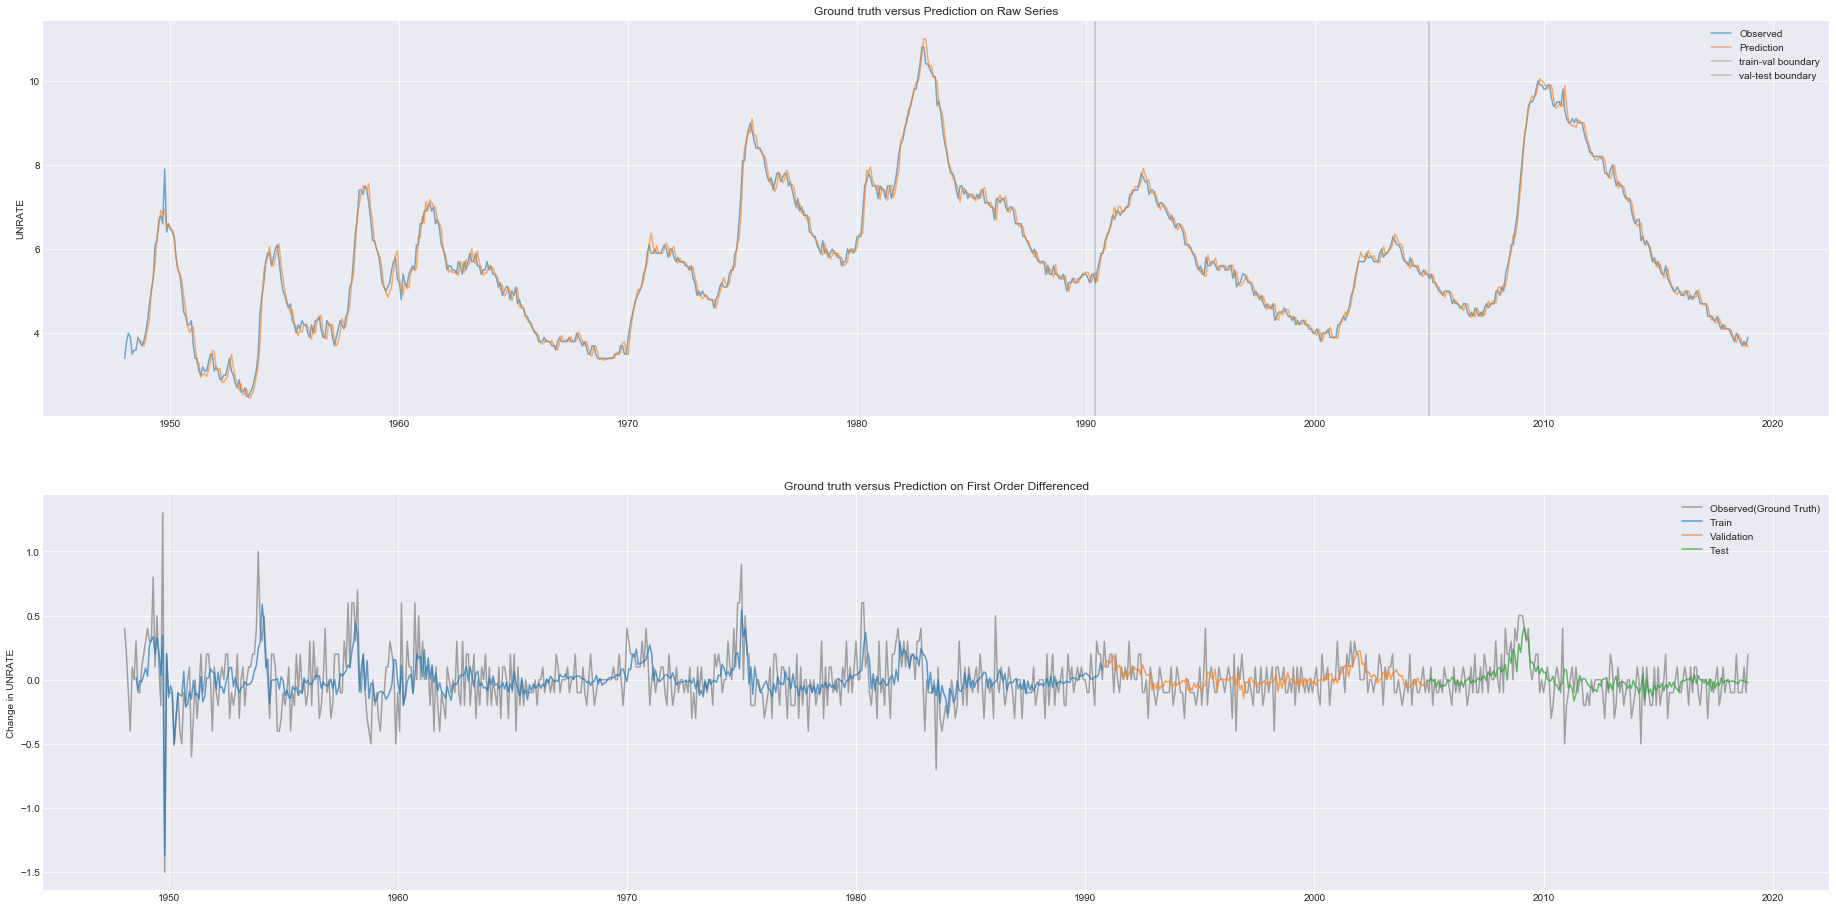

In [24]:
plt.close()
rcParams["figure.figsize"] = (32, 16)
# ==== Raw ====
ax1 = plt.subplot(2, 1, 1)
plt.title("Ground truth versus Prediction on Raw Series")
plt.plot(df, label="Observed", alpha=.6)
plt.plot(pred_raw, label="Prediction", alpha=.6)

plt.axvline(x=diff.index[len(X_train)+1], color="grey", alpha=.4, label="train-val boundary")
plt.axvline(x=diff.index[-len(X_test)+1], color="grey", alpha=.4, label="val-test boundary")
plt.grid(True)

ax1.set_ylabel(PARAMS["lab_name"])
plt.legend()

# ==== First order differenced ====
ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("Ground truth versus Prediction on First Order Differenced")
plt.plot(diff, label="Observed(Ground Truth)", color="grey", alpha=.7)
plt.plot(dfp_train, label="Train", alpha=.7)
plt.plot(dfp_val, label="Validation", alpha=.7)
plt.plot(dfp_test, label="Test", alpha=.7)
plt.legend()

ax2.set_ylabel("Change in " + PARAMS["lab_name"])
plt.grid(True)

plt.savefig(paths["fig"] + "/pred_all.png", dpi=600)
plt.show()

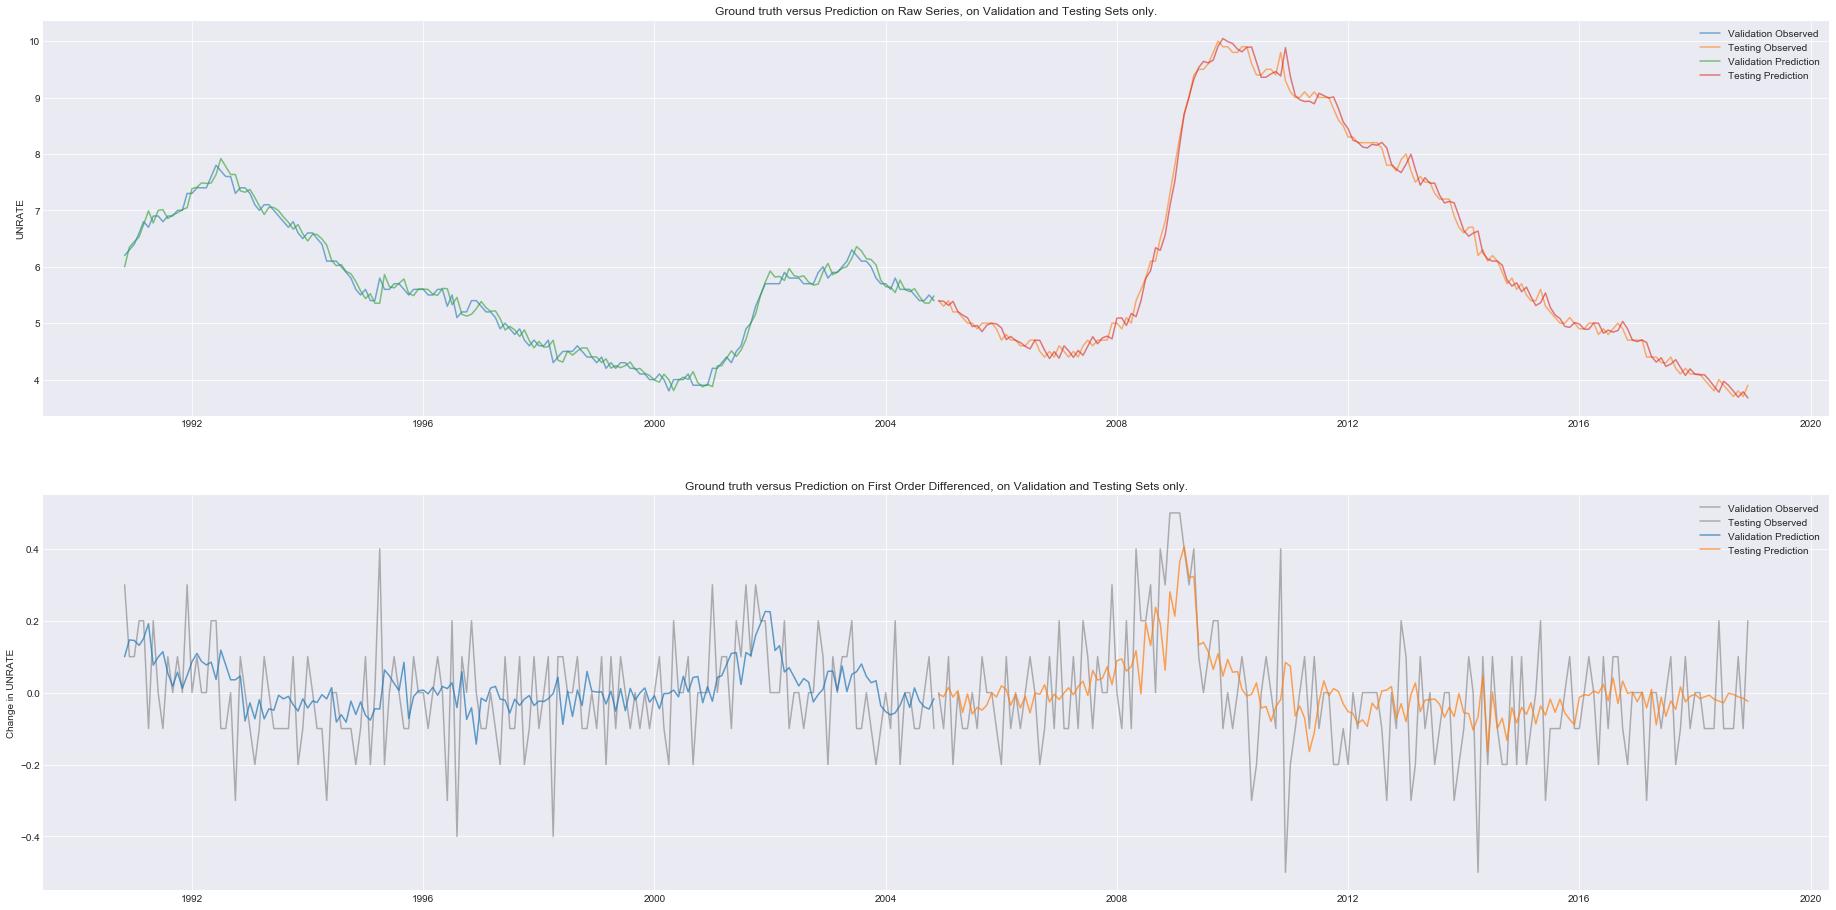

In [25]:
plt.close()
rcParams["figure.figsize"] = (32, 16)
# ==== Raw ====
ax1 = plt.subplot(2, 1, 1)
plt.title("Ground truth versus Prediction on Raw Series, on Validation and Testing Sets only.")

plt.plot(df[PARAMS["lab_name"]][ts_val], label="Validation Observed", alpha=.6)
plt.plot(df[PARAMS["lab_name"]][ts_test], label="Testing Observed", alpha=.6)

plt.plot(pred_raw[PARAMS["lab_name"]][ts_val], label="Validation Prediction", alpha=.6)
plt.plot(pred_raw[PARAMS["lab_name"]][ts_test], label="Testing Prediction", alpha=.6)

# plt.axvline(x=diff.index[len(X_train)+1], color="grey", alpha=.4, label="train-val boundary")
plt.grid(True)

ax1.set_ylabel(PARAMS["lab_name"])
plt.legend()

# ==== First order differenced ====
ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("Ground truth versus Prediction on First Order Differenced, on Validation and Testing Sets only.")

plt.plot(diff[PARAMS["lab_name"]][ts_val], label="Validation Observed", color="grey", alpha=.6)
plt.plot(diff[PARAMS["lab_name"]][ts_test], label="Testing Observed", color="grey", alpha=.6)

plt.plot(dfp_val[PARAMS["lab_name"]][ts_val], label="Validation Prediction", alpha=.7)
plt.plot(dfp_test[PARAMS["lab_name"]][ts_test], label="Testing Prediction", alpha=.7)
plt.legend()

ax2.set_ylabel("Change in " + PARAMS["lab_name"])
plt.grid(True)

plt.savefig(paths["fig"] + "/pred_off_sample.png", dpi=600)
plt.show()

## SAVE EXPERIMENT RESULTS

In [26]:
# Save predictions
dfp_train.to_csv(paths["outputs"] + "/pred_train.csv")
dfp_val.to_csv(paths["outputs"] + "/pred_val.csv")
dfp_test.to_csv(paths["outputs"] + "/pred_test.csv")

pred_raw.to_csv(paths["outputs"] + "/pred_raw.csv")

json_rec.write_param(PARAMS, log_dir=paths["base"] + "/params.json")

0